In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import false_discovery_control
from sklearn.metrics import roc_auc_score
import pandas as pd
import random
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import BRICS, Recap
import math
from rdkit import Chem
from rdkit.Chem import Descriptors
import pickle
from scipy import stats
import re
from rdkit.Chem.Draw import MolsToGridImage, rdMolDraw2D, MolsMatrixToGridImage

In [2]:
# Nature-style rcParams
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 8,
    'axes.linewidth': 0.5,
    'axes.labelsize': 9,
    'axes.titlesize': 9,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.minor.size': 1.5,
    'ytick.minor.size': 1.5,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

In [3]:
bdb = pd.read_csv("../results/FinalBDBPred.csv")

In [4]:
bdb_smiles = bdb["Ligand SMILES"].tolist()
bdb_classes = bdb["Sub_Class"].tolist()
bdb_types = set(bdb_classes)
bdb_class_to_indices = {x:list() for x in bdb_types}
for i, val in enumerate(bdb_classes):
    bdb_class_to_indices[val].append(i)

In [5]:
molar_masses = []
mols = []
for smiles in bdb_smiles:
    mol = Chem.MolFromSmiles(smiles)
    mols.append(mol)
    if mol is None:
        molar_masses.append(None)
    else:
        molar_mass = Descriptors.MolWt(mol)
        molar_masses.append(molar_mass)

In [6]:
fragments = []
for i in range(len(bdb_smiles)):
    if mols[i] is None:
        continue
    m2=BRICS.BreakBRICSBonds(mols[i])
    frags = [Chem.MolToSmiles(x,True) for x in Chem.GetMolFrags(m2,asMols=True)]
    fragments.append(frags)

In [7]:
with open("FinalBDBPredTrain.txt", "r") as file:
    txt = file.read()
    lines = txt.split("\n")
trainligands = [eval(lines[i]) + eval(lines[i+1]) for i in range(1, len(lines), 7)]
names = lines[::7]

In [8]:
#best_classes = ['ACC2', 'USP30', 'Bile acid receptor', 'Glucose-dependent insulinotropic receptor', 'NAMPT', 'Diacylglycerol O-acyltransferase']
best_classes = ['CA12', 'ACC2']

In [34]:
all_dicts = {}
for j, coi in enumerate(best_classes):
    print(f"{j}: {coi}")
    pred = bdb[coi].tolist()
    substruct_dict = {}
    off_target = {}
    for i in bdb_class_to_indices[coi]:
        if i in trainligands[names.index(coi)]:
            continue
        #frags = fragments[i]
        frags = BRICS.BRICSDecompose(mols[i], minFragmentSize=5)
        #frags = Recap.RecapDecompose(mols[i]).GetLeaves().keys()
        for ofrag in frags:
            frag = ofrag
            #frag = re.sub(r"\[\d+\*\]", "", ofrag).replace("()", "")
            if frag not in substruct_dict:
                substruct_dict[frag] = []
            substruct_dict[frag].append(pred[i])
    for frag in substruct_dict.keys():
        try:
            mfrag = Chem.MolFromSmiles(frag)
        except:
            continue
        off_target[frag] = []
        for i in bdb_class_to_indices[coi]:
            if pred[i] in substruct_dict[frag]:
                continue
            if i in trainligands[names.index(coi)]:
                continue
            if mfrag is not None and (len(mols[i].GetSubstructMatch(mfrag)) != 0):
                substruct_dict[frag].append(pred[i])
            else:
                off_target[frag].append(pred[i])
    all_dicts[coi] = (substruct_dict, off_target)

0: CA12
1: ACC2


In [40]:
ranked_subs = [sorted(sorted([(k, len(v), sum(v)/len(v)-sum(all_dicts[coi][1][k])/len(all_dicts[coi][1][k])) for k, v in all_dicts[coi][0].items()], key=lambda x:-x[1])[:25], key=lambda x:-x[2]) for coi in best_classes]

In [41]:
altnames = {"ACC2":"ACC2", "USP30":"USP30",  "Bile acid receptor": "GPBAR1", "Glucose-dependent insulinotropic receptor": "GIPR", "NAMPT":"NAMPT", "Diacylglycerol O-acyltransferase": "DGAT", "CA12":"CA12"}

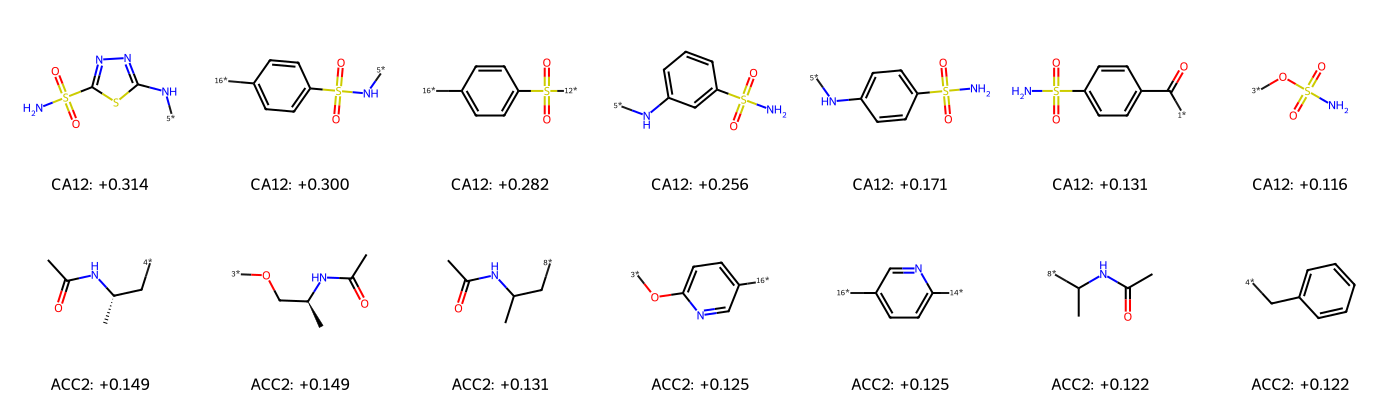

In [42]:
num = 7
molsMatrix = [[Chem.MolFromSmiles(x[0]) for x in ranked_subs[i][:num]] for i in range(len(best_classes))]
#molsMatrix = [[Chem.MolFromSmiles(re.sub(r"\[\d+\*\]", "", x[0]).replace("()", "")) for x in ranked_subs[i][:num]] for i in range(len(best_classes))]
legendsMatrix = [[altnames[best_classes[i]] + ": +" + str(x[2])[:5] for x in ranked_subs[i][:num]] for i in range(len(best_classes))]
MolsMatrixToGridImage(molsMatrix=molsMatrix, legendsMatrix=legendsMatrix)

In [44]:
Chem.MolToSmiles(molsMatrix[1][0])

'[4*]C[C@H](C)NC(C)=O'

In [514]:
class_of_interest = "CA12"
data = []
for i in range(len(bdb_smiles)):
    if molar_masses[i] is None:
        continue
    data.append([molar_masses[i], bdb[class_of_interest][i]])

In [30]:
train = [1958, 1963, 1964, 1967, 1971, 1979, 1987, 1991, 1996, 1997, 2010, 2011, 2021, 2024, 2030, 2040, 2044, 2051, 2059, 2066, 2075, 2077, 2078, 2090, 2093, 2104, 2105, 2111, 2126, 2127, 2135, 2138, 2141, 2142, 2148, 2155, 2163, 2164, 2170, 2179, 2183, 2185, 2205, 2208, 2209, 2213, 2215, 2222, 2223, 2224]

In [31]:
data_of_interest = [data[i] for i in range(len(data)) if bdb_classes[i] == class_of_interest and i not in train]

In [32]:
smiles_of_interest = [bdb_smiles[i] for i in range(len(bdb_classes)) if (molar_masses[i] is not None and bdb_classes[i] == class_of_interest)]

In [101]:
substructure_names = [
    'Sulfonamide',      # NS(=O)=O
    'Sulfamato',        # OS(=O)=O
    'Pyridine',         # n1ccccc1
    'Pyrrolidine',      # N1CCCC1
    'Furan',            # c1ccco1
    'Thiophene',        # c1cccs1
    'Acetaldehyde',     # CC=O
    'Ethylamine',       # CCN
    'Ethanol',          # CCO
    'Dimethyl ether',   # COC
    'Acetic acid'       # CC(=O)O
]

In [81]:
substructures = [
    # Sulfonamide-based (carbonic anhydrase inhibitors)
    'NS(=O)=O',    # Sulfonamide (4 atoms)
    'OS(=O)=O',    # Sulfamato (4 atoms)
    
    # Privileged nitrogen heterocycles
    'n1ccccc1',    # Pyridine (6 atoms)
    'N1CCCC1',     # Pyrrolidine (5 atoms)
    
    # Oxygen-containing scaffolds
    'c1ccco1',     # Furan (5 atoms)
    
    # Sulfur-containing motifs
    'c1cccs1',     # Thiophene (5 atoms)
    
    # Basic substructures from earlier answers
    'CC=O',        # Acetaldehyde (3 atoms)
    'CCN',         # Ethylamine (3 atoms)
    'CCO',         # Ethanol (3 atoms)
    'COC',         # Dimethyl ether (3 atoms)
    'CC(=O)O',     # Acetic acid (5 atoms)
]
substructures_of_interest = [Chem.MolFromSmiles(x) for x in substructures]

In [82]:
substructures_of_interest

In [83]:
all_has_substructure = []
for substructure_of_interest in substructures_of_interest:
    has_substructure = []
    for mol in mols:
        if mol is not None:
            has_substructure.append(len(mol.GetSubstructMatch(substructure_of_interest)) != 0)
        else:
            has_substructure.append(False)
    all_has_substructure.append(has_substructure)
    print(Chem.MolToSmiles(substructure_of_interest))

N[SH](=O)=O
O=[SH](=O)O
c1ccncc1
C1CCNC1
c1ccoc1
c1ccsc1
CC=O
CCN
CCO
COC
CC(=O)O


In [84]:
all_has_substructure_of_interest = [[has_substructure[i] for i in range(len(data)) if bdb_classes[i] == class_of_interest and i not in train] for has_substructure in all_has_substructure]

In [85]:
tcounts = [[pred[j] for j in range(len(l)) if l[j]] for l in all_has_substructure_of_interest]
fcounts = [[pred[j] for j in range(len(l)) if not l[j]] for l in all_has_substructure_of_interest]

In [86]:
[len(x) for x in tcounts]

[199, 15, 17, 4, 3, 7, 105, 128, 61, 68, 30]

In [87]:
deltas = [sum(tcounts[i])/len(tcounts[i]) - sum(fcounts[i])/len(fcounts[i]) for i in range(len(tcounts))]

In [88]:
deltas

[0.16541417964872052,
 0.11182922570582543,
 -0.04097231175784277,
 0.03687167184285767,
 -0.12011683145688035,
 -0.07935546305927876,
 -0.08231586039821837,
 -0.07170916822993123,
 -0.046938135661229285,
 0.07379304113496732,
 -0.09849270610226868]